In [1]:
from DirectDmTargets import *

calculating effective efficiency for Xe detector done
calculating effective efficiency for Ar detector done
calculating effective efficiency for Ge detector done


In [2]:
import wimprates as wr
assert wr.__version__ !='0.2.2'
wr.__version__

'0.3.0'

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import numericalunits as nu

In [5]:
from tqdm import tqdm

In [6]:
from scipy.integrate import quad as scipy_int

In [7]:
import pandas as pd

In [8]:
import scipy

In [9]:
import emcee
emcee.__version__

'3.0.0'

In [10]:
import corner

In [11]:
import time

In [12]:
import nestle

# Direct detection of Dark matter using different target materials #

Author:

Joran Angevaare <j.angevaare@nikef.nl>

Date:

14 october 2019 

## Goal ## 

- Roughly reproduce <https://journals.aps.org/prd/abstract/10.1103/PhysRevD.83.083505>
- Update the results thereof with more recent knowledge of the DM-distribution

### Approach ###
To achieve these goals, we must first get a decent recoil spectrum, that is flexible enough to have different astrophysical parameters. Further, it must also be flexible enough to be able to allow for different analytic functions to be added to the model. For instance, we must be able to incorporate the $\rm{SHM}^{++}$ as presented here <https://arxiv.org/abs/1810.11468>.

When we have a sufficiently flexible model, we want to add in the detector physics, we should therein incorporate at least the following parameters:
- target
  - material
  - cross-section
- threshold
- background
- cut efficiency  
- volume
- exposure

Finally we should perform the inference

# Emcee #
<https://emcee.readthedocs.io/en/stable/tutorials/quickstart/>

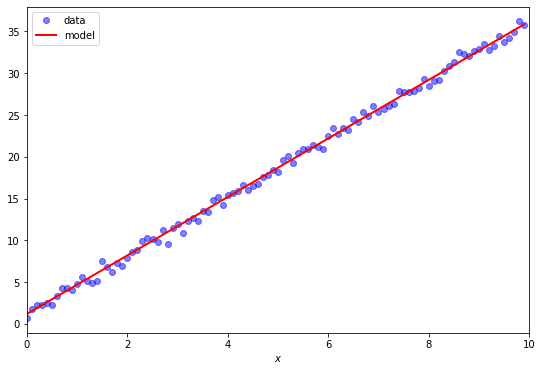

In [13]:
from scipy.special import ndtri

def prior_transform(theta):
    """
    https://mattpitkin.github.io/samplers-demo/pages/samplers-samplers-everywhere/#Nested-Sampling
    A function defining the tranform between the parameterisation in the unit hypercube
    to the true parameters.

    Args:
        theta (tuple): a tuple containing the parameters.
        
    Returns:
        tuple: a new tuple or array with the transformed parameters.
    """

    mprime, cprime = theta # unpack the parameters (in their unit hypercube form)

    cmin = -10.  # lower bound on uniform prior on c
    cmax = 10.   # upper bound on uniform prior on c

    mmu = 0.     # mean of Gaussian prior on m
    msigma = 10. # standard deviation of Gaussian prior on m

    m = mmu + msigma*ndtri(mprime) # convert back to m
    c = cprime*(cmax-cmin) + cmin  # convert back to c

    return (m, c)

# set the natural logarithm of 2pi, so that it doesn't have to be recalculated
LN2PI = np.log(2.*np.pi)
LNSIGMA = np.log(0.5) # natural log of the data noise standard deviation
M = 100

# set the true values of the model parameters for creating the data
m = 3.5 # gradient of the line
c = 1.2 # y-intercept of the line

# set the "predictor variable"/abscissa
M = 100
xmin = 0.
xmax = 10.
stepsize = (xmax-xmin)/M
x = np.arange(xmin, xmax, stepsize)

# define the model function
def straight_line(x, m, c):
    """
    A straight line model: y = m*x + c
    
    Args:
        x (list): a set of abscissa points at which the model is defined
        m (float): the gradient of the line
        c (float): the y-intercept of the line
    """

    return m*x + c

# seed our random number generator, so we have reproducible data
np.random.seed(sum([ord(v) for v in 'samplers']))

# create the data - the model plus Gaussian noise
sigma = 0.5 # standard deviation of the noise
data = straight_line(x, m, c) + sigma*np.random.randn(M)

# plot the data
# mpl.rcParams.update(rcparams) # update plot parameters
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(x, data, 'bo', alpha=0.5, label='data')
ax.plot(x, straight_line(x, m, c), 'r-', lw=2, label='model')
ax.legend()
ax.set_xlim([xmin, xmax])
ax.set_xlabel(r'$x$');

def loglikelihood_nestle(theta):
    """
    The log-likelihood function.
    """

    m, c = theta # unpack the parameters

    # normalisation
    norm = -0.5*M*LN2PI - M*LNSIGMA

    # chi-squared (data, sigma and x are global variables defined early on in this notebook)
    chisq = np.sum(((data-straight_line(x, m, c))/sigma)**2)

    return norm - 0.5*chisq

In [14]:
nlive = 1024     # number of live points
method = 'multi' # use MutliNest algorithm
ndims = 2        # two parameters
tol = 0.1        # the stopping criterion

t0 = time.time()
res = nestle.sample(loglikelihood_nestle, 
                    prior_transform, ndims, 
                    method=method, npoints=nlive, dlogz=tol)
t1 = time.time()

timenestle = (t1-t0)

print("Time taken to run 'Nestle' is {} seconds".format(timenestle))

Time taken to run 'Nestle' is 2.918795585632324 seconds


In [15]:
logZnestle = res.logz                         # value of logZ
infogainnestle = res.h                        # value of the information gain in nats
logZerrnestle = np.sqrt(infogainnestle/nlive) # estimate of the statistcal uncertainty on logZ

print('log(Z) = {} \u00B1 {}'.format(logZnestle, logZerrnestle))
print(res.summary())

# re-scale weights to have a maximum of one
nweights = res.weights/np.max(res.weights)

# get the probability of keeping a sample from the weights
keepidx = np.where(np.random.rand(len(nweights)) < nweights)[0]

# get the posterior samples
samples_nestle = res.samples[keepidx,:]
resdict ={}
resdict['mnestle_mu'] = np.mean(samples_nestle[:,0])      # mean of m samples
resdict['mnestle_sig'] = np.std(samples_nestle[:,0])      # standard deviation of m samples
resdict['cnestle_mu'] = np.mean(samples_nestle[:,1])      # mean of c samples
resdict['cnestle_sig'] = np.std(samples_nestle[:,1])      # standard deviation of c samples
resdict['ccnestle'] = np.corrcoef(samples_nestle.T)[0,1]  # correlation coefficient between parameters
resdict['nestle_npos'] = len(samples_nestle)              # number of posterior samples
resdict['nestle_time'] = timenestle                       # run time
resdict['nestle_logZ'] = logZnestle                       # log marginalised likelihood
resdict['nestle_logZerr'] = logZerrnestle                 # uncertainty on log(Z)

print('Number of posterior samples is {}'.format(len(samples_nestle)))

log(Z) = -87.79095196446784 ± 0.10111246771070997
niter: 14157
ncall: 22994
nsamples: 15181
logz: -87.791 +/-  0.101
h: 10.469
Number of posterior samples is 2765


In [16]:
print(res.summary())

niter: 14157
ncall: 22994
nsamples: 15181
logz: -87.791 +/-  0.101
h: 10.469


In [17]:
# re-scale weights to have a maximum of one
nweights = res.weights/np.max(res.weights)

# get the probability of keeping a sample from the weights
keepidx = np.where(np.random.rand(len(nweights)) < nweights)[0]

# get the posterior samples
samples_nestle = res.samples[keepidx,:]
resdict ={}
resdict['mnestle_mu'] = np.mean(samples_nestle[:,0])      # mean of m samples
resdict['mnestle_sig'] = np.std(samples_nestle[:,0])      # standard deviation of m samples
resdict['cnestle_mu'] = np.mean(samples_nestle[:,1])      # mean of c samples
resdict['cnestle_sig'] = np.std(samples_nestle[:,1])      # standard deviation of c samples
resdict['ccnestle'] = np.corrcoef(samples_nestle.T)[0,1]  # correlation coefficient between parameters
resdict['nestle_npos'] = len(samples_nestle)              # number of posterior samples
resdict['nestle_time'] = timenestle                       # run time
resdict['nestle_logZ'] = logZnestle                       # log marginalised likelihood
resdict['nestle_logZerr'] = logZerrnestle                 # uncertainty on log(Z)

print('Number of posterior samples is {}'.format(len(samples_nestle)))

Number of posterior samples is 2811


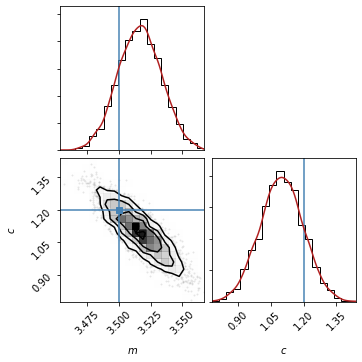

In [18]:
from scipy.stats import gaussian_kde
def plotposts(samples, **kwargs):
    """
    Function to plot posteriors using corner.py and scipy's gaussian KDE function.
    """
    if "truths" not in kwargs:
        kwargs["truths"] = [m, c]
    
    fig = corner.corner(samples, labels=[r'$m$', r'$c$'], hist_kwargs={'density': True}, **kwargs)

    # plot KDE smoothed version of distributions
    for axidx, samps in zip([0, 3], samples.T):
        kde = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick')
plotposts(samples_nestle)

## Distribution of the DM ##
First we need to make a DM-rate spectrum

In [108]:
class NestleStatModel(StatModel):
    known_parameters = ['log_mass',
                        'log_cross_section',
                        'v_0',
                        'v_esc',
                        'density']

    def __init__(self, *args):
        StatModel.__init__(self, *args)
        self.nwalkers = 50
        self.nsteps = 100
        self.fit_parameters = ['log_mass', 'log_cross_section']
        self.sampler = None
        self.pos = None
        self.log = {'sampler': False, 'did_run': False, 'pos': False}
        self.remove_frac = 0.2
        self.thin = 15
        self.config['start'] = datetime.datetime.now()  # .date().isoformat()
        self.config['notes'] = "default"

    def set_fit_parameters(self, params):
        if not type(params) == list:
            raise TypeError("Set the parameter names in a list of strings")
        for param in params:
            if param not in self.known_parameters:
                raise NotImplementedError(f"{param} does not match any of the "
                                          f"known parameters try any of "
                                          f"{self.known_parameters}")
        if not params == self.known_parameters[:len(params)]:
            raise NameError(f"The parameters are not input in the correct order"
                            f". Please insert "
                            f"{self.known_parameters[:len(params)]} rather than"
                            f" {params}.")
        self.fit_parameters = params

    def _set_pos(self, use_pos=None):
        self.log['pos'] = True
        if use_pos is not None:
            self.pos = use_pos
            return
        pos = np.hstack([
            [[np.clip(self.config['prior'][param]['dist'](
                self.config['prior'][param]['param']),
                1.25 * self.config['prior'][param]['range'][0],
                0.75 * self.config['prior'][param]['range'][-1]
            ) for i in range(self.nwalkers)]
                for param in self.fit_parameters]
        ])
        for i, p in enumerate(self.fit_parameters):
            if 'log' in p:
                pos[i] = 10 ** pos[i]
        #     # #TODO workaround
        # if 'cross' in p:
        #     pos[i] = 1e-45 + 1e-45 * np.random.rand(self.nwalkers)
        # if 'mass' in p:
        #     pos[i] = 50 + 50 * np.random.rand(self.nwalkers)
        # self.pos = pos.T
        return pos.T

    def set_pos(self, use_pos=None):
        self.log['pos'] = True
        if use_pos is not None:
            print("using specified start position")
            self.pos = use_pos
            return
        nparameters = len(self.fit_parameters)
        keys = ['mw', 'sigma', 'v_0', 'v_esc', 'rho_0'][:nparameters]
        vals = [self.config.get(key) for key in keys]

        ranges = [self.config['prior'][self.fit_parameters[i]]['range']
                  for i in range(nparameters)]
        for i, param in enumerate(self.fit_parameters):
            if 'log' in param:
                ranges[i] = [10 ** this_range for this_range in ranges[i]]
#         pos = np.hstack([
#             np.clip(
#                 #                 val + 0.001 * val * np.random.randn(self.nwalkers, 1),
#                 val + 0.25 * val * np.random.randn(self.nwalkers, 1),
#                 #                 val + 0.5 * val * np.abs(
#                 #                     np.random.randn(self.nwalkers, 1)),
#                 1. * ranges[i][0],
#                 1. * ranges[i][-1])
#             for i, val in enumerate(vals)])
        # Change
        pos = []
        for i, key in enumerate(keys):
            val = self.config.get(key)
            a, b = ranges[i]
            if key in ['sigma', 'v_0', 'v_esc', 'rho_0']:
                start_at = np.random.uniform(a, b, (self.nwalkers, 1))
            else:
                start_at = val + 0.25 * val * np.random.randn(self.nwalkers, 1)
            start_at = np.clip(start_at, a, b)
            pos.append(start_at)
        pos = np.hstack(pos)
        self.pos = pos
    #         self.pos = self._set_pos()

    def set_sampler(self, mult=True):
        ndim = len(self.fit_parameters)
        kwargs = {"threads": multiprocessing.cpu_count()} if mult else {}
        self.sampler = emcee.EnsembleSampler(self.nwalkers, ndim,
                                             self.log_probability,
                                             args=([self.fit_parameters]),
                                             **kwargs)
        self.log['sampler'] = True

    def run_emcee(self):
        if not self.log['sampler']:
            self.set_sampler()
        if not self.log['pos']:
            self.set_pos()
        try:
            self.sampler.run_mcmc(self.pos, self.nsteps, progress=True)
        except ValueError as e:
            print(f"MCMC did not finish due to a ValueError. Was running with\n"
                  f"pos={self.pos.shape} nsteps = {self.nsteps}, walkers = "
                  f"{self.nwalkers}, ndim = "
                  f"{len(self.fit_parameters)} for fit parameters "
                  f"{self.fit_parameters}")
            raise e
        self.log['did_run'] = True

    def show_walkers(self):
        if not self.log['did_run']:
            self.run_emcee()
        labels = self.fit_parameters
        fig, axes = plt.subplots(len(labels), figsize=(10, 7), sharex=True)
        samples = self.sampler.get_chain()
        for i in range(len(labels)):
            ax = axes[i]
            ax.plot(samples[:, :, i], "k", alpha=0.3)
            ax.set_xlim(0, len(samples))
            ax.set_ylabel(labels[i])
            ax.yaxis.set_label_coords(-0.1, 0.5)
        axes[-1].set_xlabel("step number")

    def show_corner(self):
        if not self.log['did_run']:
            self.run_emcee()
        print(f"Removing a fraction of {self.remove_frac} of the samples, total"
              f"number of removed samples = {self.nsteps * self.remove_frac}")
        flat_samples = self.sampler.get_chain(
            discard=int(self.nsteps * self.remove_frac),
            thin=self.thin,
            flat=True
        )
        truths = [self.config['mw'],
                  self.config['sigma'],
                  self.config['v_0'],
                  self.config['v_esc'],
                  self.config['rho_0']
                  ]
        corner.corner(flat_samples, labels=self.fit_parameters,
                            truths=truths[:len(self.fit_parameters)])

    def save_results(self, force_index=False):
        if not self.log['did_run']:
            self.run_emcee()
        base = 'results/'
        save = '2nd_test'
        files = os.listdir(base)
        files = [f for f in files if save in f]
        if not save + '0' in files:
            os.makedirs(base + save + '0')
        if force_index is False:
            index = max([int(f.split(save)[-1]) for f in files]) + 1
        else:
            index = force_index

        save_dir = base + save + str(index) + '/'
        print('save_results::\tusing ' + save_dir)
        if force_index is False:
            os.mkdir(save_dir)
        else:
            assert os.path.exists(save_dir), "specify existing directory, exit"
            for file in os.listdir(save_dir):
                print('save_results::\tremoving ' + save_dir + file)
                os.remove(save_dir + file)
        # save the config, chain and flattened chain
        with open(save_dir + 'config.json', 'w') as fp:
            json.dump(convert_dic_to_savable(self.config), fp)
        np.save(save_dir + 'config.npy',
                convert_dic_to_savable(self.config))
        np.save(save_dir + 'full_chain.npy', self.sampler.get_chain())
        np.save(save_dir + 'flat_chain.npy', self.sampler.get_chain(
            discard=int(self.nsteps * self.remove_frac), thin=self.thin,
            flat=True))
        print("save_results::\tdone_saving")
        
    def log_probability_nestle(self, parameter_vals, parameter_names):
        """

        :param parameter_vals: the values of the model/benchmark considered as
        the truth
        # :param parameter_values: the values of the parameters that are being
        varied
        :param parameter_names: the names of the parameter_values
        :return:
        """
               
        model = self.eval_spectrum(parameter_vals, parameter_names)

        ll = log_likelihood(model, self.benchmark_values)
        if np.isnan(ll):
            raise ValueError(
                f"Returned NaN from likelihood. ll = {ll}")
        return ll
    
    def log_prior_transform_nestle(self, x, x_name):
        if self.config['prior'][x_name]['prior_type'] == 'flat':
            a, b = self.config['prior'][x_name]['param']
            if 'log' in x_name:
#                 x = np.log10(x)
                a = 10**a
                b = 10**b
#             return log_flat(a, b, x)
            return x *(b-a) + a 
        elif self.config['prior'][x_name]['prior_type'] == 'gauss':
            a, b = self.config['prior'][x_name]['range']
            m, s = self.config['prior'][x_name]['param']
            aprime, bprime = spsp.ndtr((a - m) / s), spsp.ndtr((b - m) / s)
            xprime = x *(bprime - aprime) + aprime
            res =  m + s * spsp.ndtri(xprime)
#             res *= x *(b-a) + a
            return res
#             if  a < res < b:
#                 return res
#             else:
#                 return -np.inf #(1 / (a + b)) * res * (b - a) + a
#             return log_gauss(a, b, m, s, x)
        else:
            raise TypeError(
                f"unknown prior type '"
                f"{self.config['prior'][x_name]['prior_type']}', choose either "
                f"gauss or flat")
            
    def _log_probability_nestle(self, theta):
        ndim = len(self.fit_parameters)
        return self.log_probability_nestle(theta, 
            self.known_parameters[:ndim])
#         result = [self.log_probability_nestle(val, 
#                   self.known_parameters[i])
#                   for i, val in enumerate(theta)]
#         return np.array(result)
    def _log_prior_transform_nestle(self, theta):
        ndim = len(self.fit_parameters)
        result = [self.log_prior_transform_nestle(val, 
            self.known_parameters[i])
            for i, val in enumerate(theta)]
        
        return np.array(result)
test = NestleStatModel("Xe")

StatModel::	initialized for Xe detector. See print(stat_model) for default settings


544


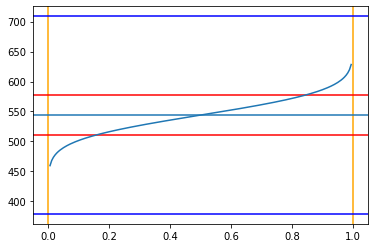

In [116]:
# xs = np.linspace(.,1,111)
xs = np.linspace(-0.05,1.05,200)
name = 'v_esc'
plt.axvline(0, c= 'orange')
plt.axvline(1, c= 'orange')
ys = [test.log_prior_transform_nestle(x, name) for x in xs]
mean = get_priors()[name]['mean']
std = get_priors()[name]['std']
print(mean)
a,b =  get_priors()[name]['range']
plt.axhline(mean)
plt.axhline(mean+std, c= 'r')
plt.axhline(mean-std, c= 'r')
plt.axhline(a, c= 'b')
plt.axhline(b, c= 'b')
plt.plot(xs,ys)

In [117]:
for i in [0, 0.5, 1]:
    print(i, test.log_prior_transform_nestle(i, name))

0 379.0
0.5 544.0
1 708.9999999990158


In [43]:
from scipy import special as spsp

In [44]:
test.fit_parameters

['log_mass', 'log_cross_section']

In [45]:
sh = SHM()

In [46]:
spec = GenSpectrum(50, 1e-45, sh, detectors["Xe"])

In [52]:
# spec.get_data(poisson=False)

In [53]:
# test.check_spectrum()

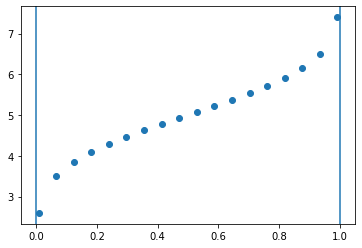

In [66]:
xs = np.linspace(-0.05,1.05,20)
# def prior_transform(x):
#     return 10. * x - 5.
def prior_transform(x):
    return 5 + 1 * ndtri(x)
plt.scatter(xs, prior_transform(xs))
plt.axvline(0)
plt.axvline(1)

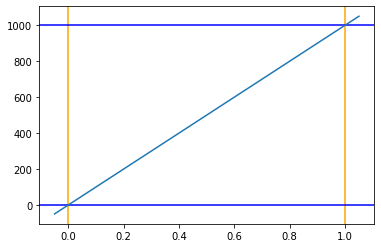

In [67]:
# xs = np.linspace(.,1,111)
xs = np.linspace(-0.05,1.05,200)
name = 'log_mass'
plt.axvline(0, c= 'orange')
plt.axvline(1, c= 'orange')
ys = [test.log_prior_transform_nestle(x, name) for x in xs]
a,b =  get_priors()[name]['range']
plt.axhline(10**a, c= 'b')
plt.axhline(10**b, c= 'b')
plt.plot(xs,ys)

In [72]:
test.log_prior_transform_nestle(1, name)

1000.0

In [31]:
nlive = 1024     # number of live points
method = 'multi' # use MutliNest algorithm
ndims = 2        # two parameters
tol = 0.5        # the stopping criterion

t0 = time.time()
res2 = nestle.sample(test._log_probability_nestle, 
                    test._log_prior_transform_nestle, 
                    ndims, 
                    method=method, 
                    npoints=nlive, 
                    dlogz=tol)
t1 = time.time()

timenestle = (t1-t0)

print("Time taken to run 'Nestle' is {} seconds".format(timenestle))

/data/xenon/joranang/software/DD_DM_targets/DirectDmTargets/statistics.py:166: RuntimeWarning: overflow encountered in double_scalars
  10 ** x0,


AssertionError: err

In [ ]:
nlive = 10       # number of live points
method = 'multi' # use MutliNest algorithm
ndims = 2        # two parameters
tol = 0.1        # the stopping criterion

t0 = time.time()
res = nestle.sample(test._log_probability_nestle, 
                    test._log_prior_transform_nestle, 
                    ndims, 
                    method=method, 
                    npoints=nlive, 
                    dlogz=tol,
                    maxiter =50)
t1 = time.time()

timenestle = (t1-t0)

print("Time taken to run 'Nestle' is {} seconds".format(timenestle))

In [ ]:
logZnestle = res.logz                         # value of logZ
infogainnestle = res.h                        # value of the information gain in nats
logZerrnestle = np.sqrt(infogainnestle/nlive) # estimate of the statistcal uncertainty on logZ

print('log(Z) = {} \u00B1 {}'.format(logZnestle, logZerrnestle))
print(res.summary())

# re-scale weights to have a maximum of one
nweights = res.weights/np.max(res.weights)

# get the probability of keeping a sample from the weights
keepidx = np.where(np.random.rand(len(nweights)) < nweights)[0]

# get the posterior samples
samples_nestle = res.samples[keepidx,:]
resdict ={}
resdict['mnestle_mu'] = np.mean(samples_nestle[:,0])      # mean of m samples
resdict['mnestle_sig'] = np.std(samples_nestle[:,0])      # standard deviation of m samples
resdict['cnestle_mu'] = np.mean(samples_nestle[:,1])      # mean of c samples
resdict['cnestle_sig'] = np.std(samples_nestle[:,1])      # standard deviation of c samples
resdict['ccnestle'] = np.corrcoef(samples_nestle.T)[0,1]  # correlation coefficient between parameters
resdict['nestle_npos'] = len(samples_nestle)              # number of posterior samples
resdict['nestle_time'] = timenestle                       # run time
resdict['nestle_logZ'] = logZnestle                       # log marginalised likelihood
resdict['nestle_logZerr'] = logZerrnestle                 # uncertainty on log(Z)

print('Number of posterior samples is {}'.format(len(samples_nestle)))

In [ ]:
p, cov = nestle.mean_and_cov(res.samples, res.weights)
print("m = {0:5.2f} +/- {1:5.2f}".format(p[0], np.sqrt(cov[0, 0])))
print("b = {0:5.2f} +/- {1:5.2f}".format(p[1], np.sqrt(cov[1, 1])))

In [ ]:
fig = corner.corner(res.samples, weights=res.weights, labels=['m', 'b'],
                    range=[0.99999, 0.99999], truths=[50, 1e-45], bins=30)
plt.show()

In [ ]:
stats.check_spectrum()

In [ ]:
stats.nwalkers = 50
stats.nsteps = 50
stats.log

In [ ]:
start = time.time()
stats.run_emcee()
end = time.time()

In [ ]:
end-start

In [ ]:
stats.save_results()

In [ ]:
7028/3600

In [ ]:
assert stats.log['did_run']

In [ ]:
stats.show_walkers()

In [ ]:
stats.show_corner()

## Full dimensionality ##

In [ ]:
stats_full = dddm.MCMCStatModel("Xe")

In [ ]:
stats_full.log

In [ ]:
# for key in stats_full.log.keys():
#     stats_full.log[key] = False


In [ ]:
stats_full.nwalkers = stats.nwalkers
stats_full.nsteps = stats.nsteps * 2
stats_full.log

In [ ]:
stats_full.fit_parameters = stats_full.known_parameters

In [ ]:
stats_full.check_spectrum()

In [ ]:
start = time.time()
stats_full.run_emcee()
end = time.time()

In [ ]:
end-start

In [ ]:
stats_full.save_results()

In [ ]:
9170.64813709259/3600

In [ ]:
assert stats_full.log['did_run']

In [ ]:
stats_full.show_walkers()

In [ ]:
stats_full.show_corner()

In [ ]:
corner.corner(
    stats_full.sampler.get_chain(
        flat=True,
        thin = 50,
        discard=int(stats_full.nsteps * 0.2)
    ),
              labels=stats_full.fit_parameters);